In [1]:
from gradio_client import Client
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.preprocessing import normalize
import faiss
import json
import re
from pprint import pprint
import torch
import faiss
import numpy as np


#  $\bold{Краткая \, выжимка \, того, \, что \, будет \, далее}$

Retrieval-Augmented Generation - способ увеличить точность предсказаний (зафайнтюнить модель) большой языковой seq2seq модели (называемой далее генератором) на специфических / не просмотренных при обучении данных.

Основу метода составляет использование векторной базы данных, наиболее релевантные записи из которой конкатенируются с основным запросом. Таким образом, 
нейросеть-генератор получает часть ответа в самом вопросе.

Почему используется именно векторная база данных? Потому что в ней можно легко ввести метрику схожести записей - евклидову, Cosine similarity или более сложную.

Как создавать векторную базу данных? Для этого нужна языковая модель (называемая далее энкодером), которая сопоставляет предложению на естественном языке некий вектор,
используя self-attention mechanism.

Можно ли использовать случайный энкодер? Да, но гарантировать, что на каждом естественном языке она будет хорошо сопоставлять записям вектора, нельзя.
На huggingface есть энкодеры, специально обученные под один из естественных языков.


# Шаг глубже

$\bold{Текст \, оригинальной \, статьи \, доступен \, по \, ссылке: \, https://arxiv.org/abs/2005.11401}$

В статье используют термины "параметрическая" и "непараметрическая" память. Под первой подразумевают предобученные веса генератора,
под второй - векторную базу данных.

Есть два подвида RAG:

1) RAG-Sequence Model: мы сначала ищем k наиболее релевантных записей в БД, конкатенируем их со всем запросом и один раз запускаем генератор;

2) RAG-Token Model: ищем топ-k записей вв БД для запроса, скармливаем модели-генератору, получаем от неё очередной токен, снова находим
топ-k документов для запроса + всех выданных моделью токенов, снова скармливаем генератору. И так, пока не дойдём до символа конца генерации EOS.

Ниже представлены различные скоры модели на датасете NQ с общими вопросами (например, "кто основал Гугл?") в зависимости от числа k

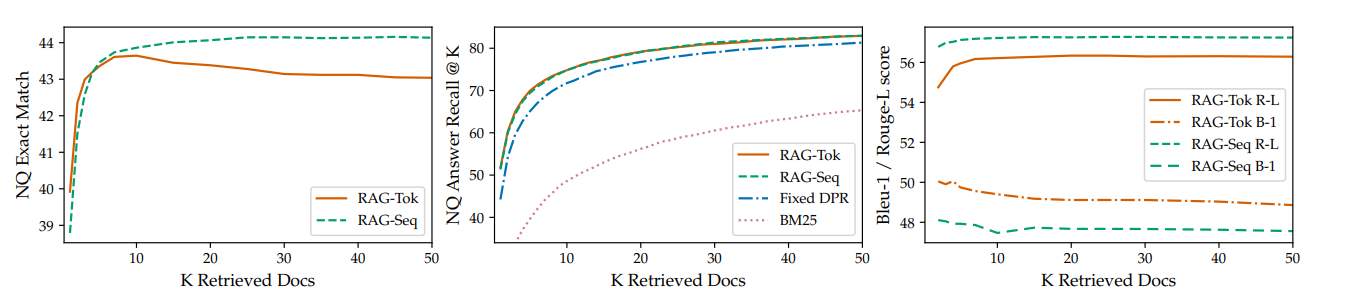

## Далее будем решать RAG-Sequence Model задачу

Пусть $z_i$ - полученные документы. $y$ - итоговый ответ генератора. Фактически, задача в состоит в следующем:

$ p_{RAG-Seq}(y|x) \approx \sum\limits_{z\in top-k(p(·|x))} p_{\eta} (z|x) \,\, p_{\theta}(y|x, z) = \sum\limits_{z\in top-k(p(·|x))}  p_{\eta} (z|x) \prod\limits_i^N p_{\theta}(y_i|x, z, y_{1:i−1}) $

Считается, что вероятность получить z-е документы с помощью энкодера с параметрами $\bold{\eta}$ при запросе x пропорционально скалярному произведению эмбеддингов запроса и документов:

$p_\eta (z|x) \propto exp(\bold{q}^T \, \bold{d}), \qquad \bold{d}(z) = BERT_d(z), \bold{q}(x) = BERT_q(x)$

В статье указано, что RAG-augmented *модель может достигать до 11,8% accuracy даже в тех вопросах, ответов на которые не было
в векторной базе данных*, при accuracy "сырой" модели 0%.

In [2]:
print(torch.cuda.is_available())

True


In [3]:
#загружаем документы в .txt формате

documents = []
text = ""
for i in range(1, 5):
    with open(f"{i}Ustav.txt", "r", encoding="utf-8") as doc:
        text = doc.read()
        documents.append({"tome" : i, "text" : text})

In [4]:
#очистка текста с помощью регулярных выражений
def clean_ustav_text(text):
    
    # 1. Убрать \x0c
    text = re.sub(r'\x0c', ' ', text)
    # 2. Убрать \x14 
    text = re.sub(r'\x14', '', text)
    # 3. Убрать спецсимволы
    text = re.sub(r'\x1f\n', '\n', text, flags=re.DOTALL)
    # 4. Убрать одинокие числа (например, номера страниц)
    text = re.sub(r'\n\d+\n', '\n', text)
    # 5. Удалить пробелы между словами, где это не нужно (опционально)
    text = re.sub(r'[ \t]{2,}', ' ', text)
    # 6. Заменить 2+ перевода строки на один
    text = re.sub(r'\n{2,}', '\n', text)
    # 7. Убрать лишние пробелы/табуляции в начале строк
    text = re.sub(r'^[ \t]+', '', text, flags=re.MULTILINE)
    # 8. Убрать лишние нижние подчеркивания
    text = re.sub(r'_{2,}', '_', text, flags=re.MULTILINE)

    cleaned_text = text.strip()

    return cleaned_text

In [5]:
for doc in documents:
    doc["text"] = clean_ustav_text(doc["text"])

In [6]:
pprint(documents[2])

{'text': 'Настоящий Устав определяет строевые приемы и дви\n'
         'жение без оружия и с оружием; строи подразделений и во\n'
         'инских частей в пешем порядке и на машинах; порядок\n'
         'выполнения воинского приветствия, проведения строевого\n'
         'смотра; положение Боевого знамени воинской части в\n'
         'строю, порядок совместного выноса и относа Государствен\n'
         'ного флага Российской Федерации и Боевого знамени воин\n'
         'ской части; обязанности военнослужащих перед построе\n'
         'нием и в строю и требования к их строевому обучению, а\n'
         'также способы передвижения военнослужащих на поле боя\n'
         'и действия при внезапном нападении противника.\n'
         'Строевым уставом руководствуются все военнослужа\n'
         'щие воинских частей, кораблей, органов военного управле\n'
         'ния, предприятий, учреждений, организаций и военных\n'
         'образовательных учреждений профессионального образо\n'
         'вани

In [7]:
#записываем на диск ля сохранности
with open("ustav_cleaned.jsonl", "w", encoding="utf-8") as f:
    for doc in documents:
        json.dump(doc, f, ensure_ascii=False)
        f.write("\n")

""" #при необходимости, читаем
documents = []
with open("ustav_cleaned.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        doc = json.loads(line)
        documents.append(doc) """

' #при необходимости, читаем\ndocuments = []\nwith open("ustav_cleaned.jsonl", "r", encoding="utf-8") as f:\n    for line in f:\n        doc = json.loads(line)\n        documents.append(doc) '

In [8]:
#разделяем документы на батчи, оставляем перекрытие по 50 символов для смысловой связи
splitter = RecursiveCharacterTextSplitter(chunk_size=450, chunk_overlap=100)

chunks = []
for doc in documents:
    for chunk in splitter.split_text(doc["text"]):
        chunks.append({"text": chunk, "source": doc["tome"]})

In [9]:
#делаем эмбеддинг документов с помощью модели, предобученной на русском корпусе
retriever = SentenceTransformer("ai-forever/sbert_large_nlu_ru", device="cuda")

texts = [chunk["text"] for chunk in chunks]
sources = [chunk['source'] for chunk in chunks]
d_embedding = retriever.encode(texts, batch_size=50, show_progress_bar=True)

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

In [10]:
#формируе запросы
query_len = 10

queries = [""] * query_len
queries[0] = 'Какие обязанности дежурного по роте'
queries[1] = 'Обязанности военнослужащего перед построением и в строю'
queries[2] = 'Что представляет собой служба в '
queries[3] = 'Какие нормативные акты регулируют жизнь и быт в ВС РФ?'
queries[4] = 'Какой вид вооружённых сил защищает воздушное пространство?'
queries[5] = 'Когда в колонне воинское приветствие не делают?'
queries[6] = 'Кто взял Грозный одним парашютно-десантным полком?'
queries[8] = 'Как ты думаешь, Глеб Самонин воевал?'
queries[9] = 'А помним ли мы славные победы над китайцами 7000 лет назад?'

In [11]:
q_embeddings = [""] * query_len
for i in range(query_len):
    q_embeddings[i] = retriever.encode([queries[i]], show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
#сохраняем векторную ДБ, записываем cosine-similarity для неё
normalized_embeddings = normalize(np.array(d_embedding), axis=1)

dimension = len(normalized_embeddings[0])
index = faiss.IndexFlatIP(dimension)
#index = faiss.IndexFlatL2(dimension)
index.add(np.array(normalized_embeddings))

#можно сохранить на диск
faiss.write_index(index, "ustav_index.faiss")

""" #и прочитать
index = faiss.read_index("ustav_index.faiss") """

' #и прочитать\nindex = faiss.read_index("ustav_index.faiss") '

In [13]:
#ищем 5 наиболее релевантных документов
k = 5

In [14]:
#...и находим

indices = []
retrieved_docs = []
retrieved_tomes =  []

for i in range(query_len):

    _, indices = index.search(np.array(q_embeddings[i]), k)
    retrieved_docs.append([texts[idx] for idx in indices[0]])
    retrieved_tomes.append([sources[idx] for idx in indices[0]])

In [15]:
retrieved_docs[7]

['дистанцию вую руку в правой руке ным светом разма\nвверх, а левую желтый, а в ле хивать в верти\nвытянуть го вой красный кальной плоско\nризонтально в флажок сти, описывая\nсторону и раз восьмерку\nмахивать ею\nвниз и вверх до\nуровня плеча\n10 Стой (стоп) Поднять левую То же, с крас Фонарем с крас\nруку в вверх и ным флажком в ным светом разма\nбыстро спус левой руке хивать по верти\nтить вниз пе кали вверх и вниз\nред собой, по\nвторяя до ис\nполнения',
 'ному пункту, дежурный по штабу полка, назначенные из\nчисла офицеров и прапорщиков, вооружаются пистолетами\nс двумя снаряженными магазинами.\n144\nДежурный по парку, дежурный по контрольно\nпропускному пункту, дежурный по штабу полка, назна\nченные из числа сержантов, помощники дежурного по кон\nтрольно\x1fпропускному пункту, дежурные и дневальные по\nподразделениям, кроме военнослужащих женского пола,',
 'вую руку вверх флажком в пра светом вначале\nи опустить ее, вой руке держать еподвиж\nдержа пред но, а затем сигнал\nплечье в

In [16]:
#конкатенируем найденное с запросом
full_inputs = [""] * query_len
context = [""] * query_len
for i in range(query_len):
    context[i] = "\n".join(retrieved_docs[i])
    full_inputs[i] = f"Question: {queries[i]}\nContext: {context[i]}"

In [17]:
pprint(full_inputs[5])

('Question: Когда в колонне воинское приветствие не делают?\n'
 'Context: военный оркестр сопровождают встречаемое лицо поворо&\n'
 'том головы.\n'
 'После обхода фронта почетного караула и ответа карау&\n'
 'ла на приветствие встречаемого лица начальник караула\n'
 'опускает руку от головного убора, для вооруженных кара&\n'
 'бинами подает команду «К но&ГЕ» и перестраивает почет&\n'
 'ный караул в колонну по три (по четыре). Затем почетный\n'
 'караул и военный оркестр проходят торжественным мар&\n'
 'шем мимо встречаемого лица.\n'
 'ного строя в колонну по два производится поворотом роты\n'
 'направо, а из колонны по два в развернутый двухшеренож\n'
 'ный строй — поворотом налево.\n'
 '49\n'
 'Выполнение воинского приветствия в строю на месте\n'
 'и в движении\n'
 '123. Для выполнения воинского приветствия в строю на\n'
 'месте, когда начальник подойдет на 40–50 шагов, коман\n'
 'дир роты подает команду «Рота, СМИРНО, равнение на\n'
 'ПРАВО (наЛЕВО, наСРЕДИНУ)».\n'
 'По этой команде 

In [18]:
#получаем доступ к генератору Qwen
client = Client("Qwen/Qwen2.5", verbose=True);

Loaded as API: https://qwen-qwen2-5.hf.space ✔


In [19]:
#делаем запросы без RAC
resultsBase = [""] * query_len

try:
    for i in range(query_len):
        resultsBase[i] = client.predict(
                    query=queries[i],
                    radio="72B",
                    api_name="/model_chat"
                );
    client.reset_session();

except Exception as e:
    print(f"Ошибка при обращении к API: {str(e)}")

In [20]:
#и с ним

results = [""] * query_len

try:
    for i in range(query_len):
        results[i] = client.predict(
                query=full_inputs[i],
                radio="72B",
                api_name="/model_chat"
            );
    client.reset_session();

except Exception as e:
    print(f"Ошибка при обращении к API: {str(e)}")

In [30]:
num = 8

In [31]:
pprint(resultsBase[num][1][0][1]['text'])

('Я не располагаю достоверной информацией о том, участвовал ли конкретно Глеб '
 'Самонин в боевых действиях. Без проверенных источников нельзя с уверенностью '
 'утверждать или опровергать его участие в войне. Если вам нужна точная '
 'информация, рекомендую обратиться к официальным архивным данным или '
 'биографическим источникам, подтвержденным документально.')


In [32]:
pprint(results[num][1][0][1]['text'])

('Исходя из предоставленного контекста, который описывает процедуры и команды, '
 'используемые во время военных парадов и церемоний, нет прямых указаний или '
 'информации о том, участвовал ли конкретно Глеб Самонин в боевых действиях. '
 'Контекст не содержит персональных данных о конкретных людях, за исключением '
 'общего описания действий военнослужащих.\n'
 '\n'
 'Если вы хотите узнать, участвовал ли Глеб Самонин в боевых действиях, вам '
 'потребуется более специфическая информация или источник, например, '
 'биографические данные, военные записи или интервью с самим человеком или его '
 'знакомыми. Без такой информации невозможно сделать вывод о его участии в '
 'боевых действиях.')
